In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [7]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=0)

## Cross Validation

In [34]:
pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(random_state=1, max_iter=10000)
)

scores = cross_val_score(pipe, X_train, y_train, cv=10, n_jobs=-1)

In [35]:
m = scores.mean()
sd = scores.std()
print(f'Accuracy: {m:.2f} +/- {sd:.2f}')

Accuracy: 0.97 +/- 0.05


## Learning Curve

[0.06301644 0.06039264 0.08357952 0.06486723 0.05455878 0.0400782
 0.05472797 0.05492284 0.05472797 0.05472797]


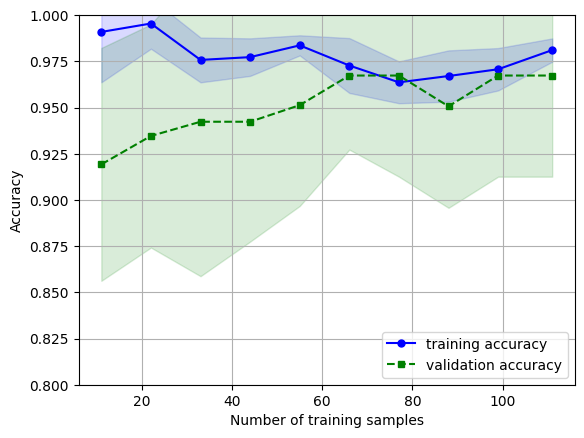

In [36]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y=y_train, train_sizes=np.linspace(.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(test_std)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([.8, 1.0])
plt.show()

## Validation Curve

[0.01570186 0.10451077 0.0660723  0.05472797 0.05472797 0.05455878
 0.07082971 0.07082971]


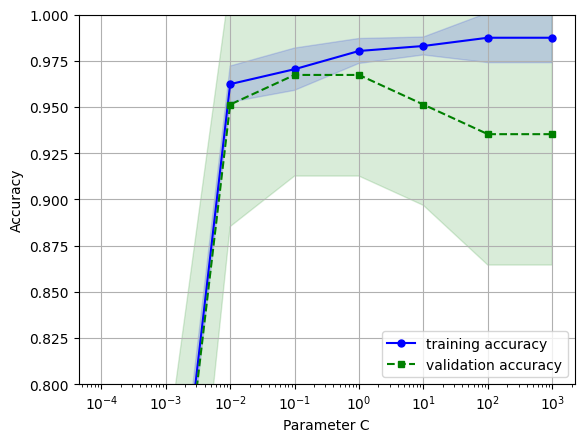

In [37]:
from sklearn.model_selection import validation_curve

param_range = [10**i for i in range(-4, 4)]
train_scores, test_scores = validation_curve(estimator=pipe, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(test_std)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([.8, 1.0])
plt.show()

## Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    PCA(),
    SVC(random_state=1))

param_range = [10**i for i in range(-4, 4)]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear'], 'pca__n_components': [1, 2, 3, 4, 5, 6, 7, None]},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf'], 'pca__n_components': [1, 2, 3, 4, 5, 6, 7, None]}
]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9762820512820513
{'pca__n_components': 3, 'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [43]:
gs.score(X_test, y_test)

0.9814814814814815

## Randomized Search

In [54]:
from scipy.stats import loguniform
param_range = loguniform(1e-4, 1e4)

from sklearn.model_selection import RandomizedSearchCV

param_distributions = [
    {'svc__C': param_range, 'svc__kernel': ['linear'], 'pca__n_components': [1, 2, 3, 4, 5, 6, 7, None]},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf'], 'pca__n_components': [1, 2, 3, 4, 5, 6, 7, None]}
]

rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_distributions, scoring='accuracy', cv=10, n_jobs=-1, n_iter=40, random_state=1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

rs.score(X_test, y_test)

0.9673076923076923
{'pca__n_components': None, 'svc__C': 0.058141444354104045, 'svc__kernel': 'linear'}


1.0

## Nested Cross Validation

In [58]:
pipe_svc = make_pipeline(
    StandardScaler(),
    PCA(),
    SVC(random_state=1))

param_range = [10**i for i in range(-4, 4)]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear'], 'pca__n_components': [1, 2, 3, 4, 5, 6, 7, None]},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf'], 'pca__n_components': [1, 2, 3, 4, 5, 6, 7, None]}
]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
gs.fit(X_train, y_train)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print(f'Accuracy: {scores.mean():.2f} +/- {scores.std():.2f}')

Accuracy: 0.96 +/- 0.04


In [59]:
gs.best_params_

{'pca__n_components': 4, 'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}